In [1]:
## Imports 
import eli5
from eli5.sklearn import PermutationImportance
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import plot_importance

In [2]:
df = pd.read_csv('df.csv')

In [3]:
# Converting DATE to datetime and extracting year and month
df['DATE'] = pd.to_datetime(df['DATE'])
df['YEAR'] = df['DATE'].dt.year
df['MONTH'] = df['DATE'].dt.month

In [4]:
# Creating additional features with lagged valuues and lag differences 
feature_names = ['SIX_MONTH_DEMAND','COPPER_PRICE', 'BUY_PRICE', 'GLOBAL_CONSUMER_PRICE_INDEX', 'GOLD_PRICE', 'INVENTORY']
steps = 5

for f in feature_names:
    for i in range(steps):
        df[f+str(i+1)] = df[f].shift(i+1)

for f in feature_names:
    for i in range(steps):
        df[f+str(i+1)+'_DIFF'] = df[f].diff().shift(i+1)
        
# Dropping rows with NaN values created during lagging
df.dropna(inplace=True)

In [5]:
df

,DATE,COPPER_PRICE,BUY_PRICE,GLOBAL_CONSUMER_PRICE_INDEX,SIX_MONTH_DEMAND,GOLD_PRICE,INVENTORY,YEAR,MONTH,SIX_MONTH_DEMAND1,...,GOLD_PRICE1_DIFF,GOLD_PRICE2_DIFF,GOLD_PRICE3_DIFF,GOLD_PRICE4_DIFF,GOLD_PRICE5_DIFF,INVENTORY1_DIFF,INVENTORY2_DIFF,INVENTORY3_DIFF,INVENTORY4_DIFF,INVENTORY5_DIFF
6,2020-07-01,3.361192,2.852747,124.142663,24.776800,2111.740211,39.313434,2020,7,26.707138,...,-217.073405,-6.099314,203.964606,-424.545335,-5.473622,-6.664805,-5.571284,11.703795,-5.779173,22.852155
7,2020-08-01,3.351726,2.849279,124.602510,23.755613,1934.702106,8.617363,2020,8,24.776800,...,215.538772,-217.073405,-6.099314,203.964606,-424.545335,11.050826,-6.664805,-5.571284,11.703795,-5.779173
8,2020-09-01,3.553568,3.057332,125.818903,11.625787,1968.907194,27.060201,2020,9,23.755613,...,-177.038105,215.538772,-217.073405,-6.099314,203.964606,-30.696070,11.050826,-6.664805,-5.571284,11.703795
9,2020-10-01,3.547297,3.049680,127.087349,19.278331,2102.212548,5.978621,2020,10,11.625787,...,34.205088,-177.038105,215.538772,-217.073405,-6.099314,18.442838,-30.696070,11.050826,-6.664805,-5.571284
10,2020-11-01,3.677784,3.177282,126.879586,22.813183,1895.376389,29.507851,2020,11,19.278331,...,133.305354,34.205088,-177.038105,215.538772,-217.073405,-21.081580,18.442838,-30.696070,11.050826,-6.664805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2027-12-01,3.510925,3.032640,196.290341,47.405890,2348.688526,22.279791,2027,12,35.492744,...,6.838519,-152.974374,106.109477,101.855755,-315.956383,-20.432745,24.485301,-12.179145,-17.016925,9.273390
96,2028-01-01,3.397751,2.905826,197.409496,49.262588,2034.178653,6.486046,2028,1,47.405890,...,319.297157,6.838519,-152.974374,106.109477,101.855755,8.404347,-20.432745,24.485301,-12.179145,-17.016925
97,2028-02-01,3.251829,2.763559,199.246402,52.169598,1842.176256,46.331669,2028,2,49.262588,...,-314.509873,319.297157,6.838519,-152.974374,106.109477,-15.793745,8.404347,-20.432745,24.485301,-12.179145
98,2028-03-01,3.259828,2.796132,199.289260,51.048567,2224.503966,39.992547,2028,3,52.169598,...,-192.002397,-314.509873,319.297157,6.838519,-152.974374,39.845623,-15.793745,8.404347,-20.432745,24.485301


In [6]:
# Splitting the data into train and test sets
train_size = int(0.8 * df.shape[0])
y = df['SIX_MONTH_DEMAND']

In [7]:
# Testing out Naive model - Sanity check
MAE_naive =  mean_absolute_error(df['SIX_MONTH_DEMAND'].iloc[1:], df['SIX_MONTH_DEMAND'].shift(1).iloc[1:])
R2_naive = r2_score(df['SIX_MONTH_DEMAND'].iloc[1:], df['SIX_MONTH_DEMAND'].shift(1).iloc[1:])
MAPE_naive = mean_absolute_percentage_error(df['SIX_MONTH_DEMAND'].iloc[1:], df['SIX_MONTH_DEMAND'].shift(1).iloc[1:]) * 100
print(f"Naive model:  MAE={MAE_naive:.3f} | MAPE={MAPE_naive:.3f}% | R2={R2_naive:.3f}")

Naive model:  MAE=5.913 | MAPE=19.202% | R2=0.435


In [8]:
features_configs = [
    ['COPPER_PRICE', 'BUY_PRICE', 'GLOBAL_CONSUMER_PRICE_INDEX', 'GOLD_PRICE', 'INVENTORY', 'MONTH', 'YEAR'], #SET 0   
    
    [f+str(i+1) for i in range(steps) for f in feature_names]+\
    ['COPPER_PRICE', 'BUY_PRICE', 'GLOBAL_CONSUMER_PRICE_INDEX', 'GOLD_PRICE', 'INVENTORY', 'MONTH', 'YEAR'], #SET 1
    
    [f+str(i+1)+'_DIFF' for i in range(steps) for f in feature_names]+\
    ['COPPER_PRICE', 'BUY_PRICE', 'GLOBAL_CONSUMER_PRICE_INDEX', 'GOLD_PRICE', 'INVENTORY', 'MONTH', 'YEAR'], #SET 2
    
    [f+str(i+1) for i in range(steps) for f in feature_names]+\
    [f+str(i+1)+'_DIFF' for i in range(steps) for f in feature_names]+\
    ['COPPER_PRICE', 'BUY_PRICE', 'GLOBAL_CONSUMER_PRICE_INDEX', 'GOLD_PRICE', 'INVENTORY', 'MONTH', 'YEAR'], #SET 3
    
]
models = [
    Lasso(random_state=42),
    Ridge(random_state=42),
    RandomForestRegressor(random_state=42),
    XGBRegressor(random_state=42), 
]

# Experiments

In [9]:
# First Experiment - No normmalization, hyperparameter tuning, detrending
print(f"naive MAE: {MAE_naive:.3f} \n")
best_MAE = float('inf')
best_model_info = ""

for i, features in enumerate(features_configs):
    for m in models:
        X = df.loc[:, features]        
        
        X_train = X.iloc[:train_size]
        X_test = X.iloc[train_size:]
        y_train = y[:train_size]
        y_test = y[train_size:]
        
        m.fit(X_train, y_train)
        y_pred = m.predict(X_test)
        
        current_MAE = mean_absolute_error(y_test, y_pred)
        current_MAPE = mean_absolute_percentage_error(y_test, y_pred) * 100
        current_R2 = r2_score(y_test, y_pred)
        
        print('Set:', i, str(m)[:12] +
              f" MAE: {current_MAE:.3f}  " +
              f"MAPE: {current_MAPE:.3f}%  " +
              f"R2 Score: {current_R2:.3f}")
        
        if current_MAE < best_MAE:
            best_MAE = current_MAE
            best_model_info = f"Set: {i}, Model: {str(m)[:12]}, MAE: {best_MAE:.3f}, MAPE: {current_MAPE:.3f}%, R2: {current_R2:.3f}"

print("\nBest Model:")
print(best_model_info)


naive MAE: 5.913 

Set: 0 Lasso(random MAE: 5.908  MAPE: 14.160%  R2 Score: 0.376
Set: 0 Ridge(random MAE: 5.670  MAPE: 13.812%  R2 Score: 0.413
Set: 0 RandomForest MAE: 6.085  MAPE: 14.156%  R2 Score: 0.234
Set: 0 XGBRegressor MAE: 6.654  MAPE: 15.084%  R2 Score: 0.058
Set: 1 Lasso(random MAE: 5.015  MAPE: 12.450%  R2 Score: 0.460
Set: 1 Ridge(random MAE: 5.489  MAPE: 13.476%  R2 Score: 0.393
Set: 1 RandomForest MAE: 6.754  MAPE: 15.637%  R2 Score: 0.134
Set: 1 XGBRegressor MAE: 8.415  MAPE: 18.715%  R2 Score: -0.393
Set: 2 Lasso(random MAE: 5.519  MAPE: 13.544%  R2 Score: 0.358
Set: 2 Ridge(random MAE: 5.417  MAPE: 13.347%  R2 Score: 0.435
Set: 2 RandomForest MAE: 7.347  MAPE: 16.569%  R2 Score: 0.006
Set: 2 XGBRegressor MAE: 7.893  MAPE: 18.295%  R2 Score: -0.084
Set: 3 Lasso(random MAE: 4.848  MAPE: 11.923%  R2 Score: 0.467
Set: 3 Ridge(random MAE: 5.054  MAPE: 12.400%  R2 Score: 0.450
Set: 3 RandomForest MAE: 7.472  MAPE: 16.844%  R2 Score: -0.022
Set: 3 XGBRegressor MAE: 7.930  M

In [10]:
X.iloc[:,:-2]

,SIX_MONTH_DEMAND1,COPPER_PRICE1,BUY_PRICE1,GLOBAL_CONSUMER_PRICE_INDEX1,GOLD_PRICE1,INVENTORY1,SIX_MONTH_DEMAND2,COPPER_PRICE2,BUY_PRICE2,GLOBAL_CONSUMER_PRICE_INDEX2,...,COPPER_PRICE5_DIFF,BUY_PRICE5_DIFF,GLOBAL_CONSUMER_PRICE_INDEX5_DIFF,GOLD_PRICE5_DIFF,INVENTORY5_DIFF,COPPER_PRICE,BUY_PRICE,GLOBAL_CONSUMER_PRICE_INDEX,GOLD_PRICE,INVENTORY
6,26.707138,3.210040,2.712150,122.889549,1896.201439,28.262608,31.061250,3.220652,2.707316,121.855462,...,-0.056470,-0.059594,3.142787,-5.473622,22.852155,3.361192,2.852747,124.142663,2111.740211,39.313434
7,24.776800,3.361192,2.852747,124.142663,2111.740211,39.313434,26.707138,3.210040,2.712150,122.889549,...,0.036313,-0.004646,1.645629,-424.545335,-5.779173,3.351726,2.849279,124.602510,1934.702106,8.617363
8,23.755613,3.351726,2.849279,124.602510,1934.702106,8.617363,24.776800,3.361192,2.852747,124.142663,...,0.063286,0.120320,1.696295,203.964606,11.703795,3.553568,3.057332,125.818903,1968.907194,27.060201
9,11.625787,3.553568,3.057332,125.818903,1968.907194,27.060201,23.755613,3.351726,2.849279,124.602510,...,0.040427,-0.009878,-2.628320,-6.099314,-5.571284,3.547297,3.049680,127.087349,2102.212548,5.978621
10,19.278331,3.547297,3.049680,127.087349,2102.212548,5.978621,11.625787,3.553568,3.057332,125.818903,...,-0.010612,0.004833,1.034087,-217.073405,-6.664805,3.677784,3.177282,126.879586,1895.376389,29.507851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,35.492744,3.597004,3.077821,195.835890,2029.391369,13.875444,30.873478,3.708083,3.182203,197.363571,...,0.139212,0.175203,-0.153211,-315.956383,9.273390,3.510925,3.032640,196.290341,2348.688526,22.279791
96,47.405890,3.510925,3.032640,196.290341,2348.688526,22.279791,35.492744,3.597004,3.077821,195.835890,...,-0.047617,-0.058618,1.941719,101.855755,-17.016925,3.397751,2.905826,197.409496,2034.178653,6.486046
97,49.262588,3.397751,2.905826,197.409496,2034.178653,6.486046,47.405890,3.510925,3.032640,196.290341,...,0.065035,0.076989,-0.450345,106.109477,-12.179145,3.251829,2.763559,199.246402,1842.176256,46.331669
98,52.169598,3.251829,2.763559,199.246402,1842.176256,46.331669,49.262588,3.397751,2.905826,197.409496,...,0.139111,0.108179,3.832521,-152.974374,24.485301,3.259828,2.796132,199.289260,2224.503966,39.992547


In [11]:
# Second Experiment - Normalization
print(f"naive MAE: {MAE_naive:.3f} \n")
best_MAE = float('inf')
best_model_info = ""

for i, features in enumerate(features_configs):
    for m in models:
        X = df.loc[:, features]        

        X_train = X.iloc[:train_size]
        X_test = X.iloc[train_size:]
        y_train = y[:train_size]
        y_test = y[train_size:]

        columns_to_scale = X.columns[:-2] 
        columns_not_to_scale = X.columns[-2:] # year and month columns

        X_train_s = X_train.copy()
        X_test_s = X_test.copy()
        
        scaler = MinMaxScaler()
        X_train_s[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
        X_test_s[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
        
        m.fit(X_train_s, y_train)
        y_pred = m.predict(X_test_s)
        
        current_MAE = mean_absolute_error(y_test, y_pred)
        current_MAPE = mean_absolute_percentage_error(y_test, y_pred) * 100
        current_R2 = r2_score(y_test, y_pred)
        
        print('Set:', i, str(m)[:12] +
              f" MAE: {current_MAE:.3f}  " +
              f"MAPE: {current_MAPE:.3f}%  " +
              f"R2 Score: {current_R2:.3f}")
        
        if current_MAE < best_MAE:
            best_MAE = current_MAE
            best_model_info = f"Set: {i}, Model: {str(m)[:12]}, MAE: {best_MAE:.3f}, MAPE: {current_MAPE:.3f}%, R2: {current_R2:.3f}"

print("\nBest Model:")
print(best_model_info)

naive MAE: 5.913 

Set: 0 Lasso(random MAE: 5.811  MAPE: 13.881%  R2 Score: 0.320
Set: 0 Ridge(random MAE: 5.544  MAPE: 13.606%  R2 Score: 0.421
Set: 0 RandomForest MAE: 6.085  MAPE: 14.156%  R2 Score: 0.234
Set: 0 XGBRegressor MAE: 6.654  MAPE: 15.084%  R2 Score: 0.058
Set: 1 Lasso(random MAE: 5.811  MAPE: 13.881%  R2 Score: 0.320
Set: 1 Ridge(random MAE: 4.930  MAPE: 12.369%  R2 Score: 0.447
Set: 1 RandomForest MAE: 6.754  MAPE: 15.637%  R2 Score: 0.134
Set: 1 XGBRegressor MAE: 8.415  MAPE: 18.715%  R2 Score: -0.393
Set: 2 Lasso(random MAE: 5.811  MAPE: 13.881%  R2 Score: 0.320
Set: 2 Ridge(random MAE: 5.366  MAPE: 13.049%  R2 Score: 0.443
Set: 2 RandomForest MAE: 7.347  MAPE: 16.569%  R2 Score: 0.006
Set: 2 XGBRegressor MAE: 7.893  MAPE: 18.295%  R2 Score: -0.084
Set: 3 Lasso(random MAE: 5.811  MAPE: 13.881%  R2 Score: 0.320
Set: 3 Ridge(random MAE: 5.320  MAPE: 12.941%  R2 Score: 0.477
Set: 3 RandomForest MAE: 7.472  MAPE: 16.844%  R2 Score: -0.022
Set: 3 XGBRegressor MAE: 7.930  M

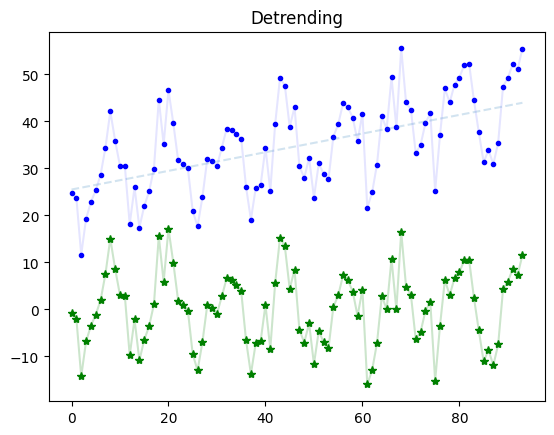

In [12]:
# Detrending
x = np.array(range(len(y)))

z = np.polyfit(x[:train_size], y[:train_size], 1)
p = np.poly1d(z)

y_trend = p(x)
y_det = y - y_trend

plt.plot(x,y, 'b.')
plt.plot(x,y, 'b-', alpha=0.1)
plt.plot(x,y_trend, '--', alpha=0.2)
plt.plot(x,y_det, 'g*')
plt.plot(x,y_det, 'g-', alpha=0.2)
plt.title('Detrending')
plt.show()


In [13]:
# Third Experiment - Detrending 

print(f"naive MAE: {MAE_naive:.3f} \n")
best_MAE = float('inf')
best_model_info = ""

for i, features in enumerate(features_configs):
    for m in models:
        X = df.loc[:, features]        
        
        X_train = X.iloc[:train_size]
        X_test = X.iloc[train_size:]
        y_train = y_det[:train_size]
        y_test = y[train_size:]
        
        columns_to_scale = X.columns[:-2] 
        columns_not_to_scale = X.columns[-2:] # year and month columns

        X_train_s = X_train.copy()
        X_test_s = X_test.copy()
        
        scaler = MinMaxScaler()
        X_train_s[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
        X_test_s[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
        
        m.fit(X_train_s, y_train)
        y_pred = m.predict(X_test_s) + y_trend[train_size:]
        
        current_MAE = mean_absolute_error(y_test, y_pred)
        current_MAPE = mean_absolute_percentage_error(y_test, y_pred) * 100
        current_R2 = r2_score(y_test, y_pred)
        
        print('Set:', i, str(m)[:12] +
              f" MAE: {current_MAE:.3f}  " +
              f"MAPE: {current_MAPE:.3f}%  " +
              f"R2 Score: {current_R2:.3f}")
        
        if current_MAE < best_MAE:
            best_MAE = current_MAE
            best_model_info = f"Set: {i}, Model: {str(m)[:12]}, MAE: {best_MAE:.3f}, MAPE: {current_MAPE:.3f}%, R2: {current_R2:.3f}"
            best_preds = y_pred
print("\nBest Model:")
print(best_model_info)

naive MAE: 5.913 

Set: 0 Lasso(random MAE: 5.520  MAPE: 13.806%  R2 Score: 0.399
Set: 0 Ridge(random MAE: 5.523  MAPE: 13.578%  R2 Score: 0.424
Set: 0 RandomForest MAE: 3.884  MAPE: 10.158%  R2 Score: 0.682
Set: 0 XGBRegressor MAE: 4.779  MAPE: 12.728%  R2 Score: 0.539
Set: 1 Lasso(random MAE: 5.520  MAPE: 13.806%  R2 Score: 0.399
Set: 1 Ridge(random MAE: 4.930  MAPE: 12.383%  R2 Score: 0.450
Set: 1 RandomForest MAE: 3.883  MAPE: 10.405%  R2 Score: 0.662
Set: 1 XGBRegressor MAE: 4.970  MAPE: 13.517%  R2 Score: 0.452
Set: 2 Lasso(random MAE: 5.520  MAPE: 13.806%  R2 Score: 0.399
Set: 2 Ridge(random MAE: 5.361  MAPE: 13.046%  R2 Score: 0.445
Set: 2 RandomForest MAE: 4.565  MAPE: 11.470%  R2 Score: 0.607
Set: 2 XGBRegressor MAE: 5.347  MAPE: 13.208%  R2 Score: 0.512
Set: 3 Lasso(random MAE: 5.520  MAPE: 13.806%  R2 Score: 0.399
Set: 3 Ridge(random MAE: 5.313  MAPE: 12.931%  R2 Score: 0.480
Set: 3 RandomForest MAE: 4.347  MAPE: 11.169%  R2 Score: 0.633
Set: 3 XGBRegressor MAE: 4.930  MAPE

In [16]:
# Hiperparameter tuning xgbregressor
features = features_configs[1]
tscv = TimeSeriesSplit(n_splits=5)
model = XGBRegressor()

X = df.loc[:, features]        
        
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y_det[:train_size]
y_test = y[train_size:]

columns_to_scale = X.columns[:-2] 
columns_not_to_scale = X.columns[-2:] # year and month columns

X_train_s = X_train.copy()
X_test_s = X_test.copy()

scaler = MinMaxScaler()
X_train_s[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test_s[columns_to_scale] = scaler.transform(X_test[columns_to_scale])


param_grid = {
    'n_estimators': [250,300,400],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'min_child_weight': [3, 4, 5],
}

grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

grid_search.fit(X_train_s, y_train)
print(grid_search.best_params_)
print(f'Best MAE: {-grid_search.best_score_}')

best_model = grid_search.best_estimator_
best_model.fit(X_train_s, y_train)

y_pred = best_model.predict(X_test_s) + y_trend[train_size:]

mae_full = mean_absolute_error(y_test, y_pred)
mape_full = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"MAE on the test set after training on full data: {mae_full:.3f}")
print(f"MAPE on the test set after training on full data: {mape_full:.3f}%")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 250, 'subsample': 0.7}
Best MAE: 4.949978372713381
MAE on the test set after training on full data: 4.720
MAPE on the test set after training on full data: 12.482%


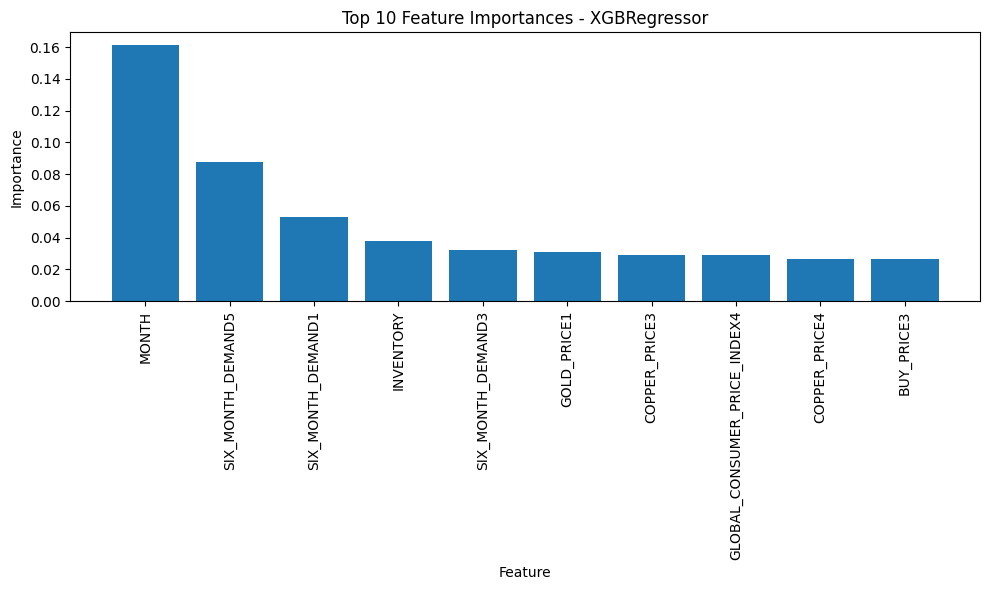

In [17]:
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': best_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Top 10 Feature Importances - XGBRegressor')
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [18]:
perm_importance = PermutationImportance(best_model, random_state=42).fit(X_test_s, y_test)

eli5.show_weights(perm_importance, feature_names=X.columns.tolist())

Weight,Feature
0.4191 ± 0.0647,MONTH
0.0847 ± 0.1375,GOLD_PRICE
0.0587 ± 0.0746,GOLD_PRICE1
0.0572 ± 0.0736,SIX_MONTH_DEMAND5
0.0457 ± 0.0847,GOLD_PRICE5
0.0354 ± 0.0685,COPPER_PRICE5
0.0354 ± 0.0334,GOLD_PRICE2
0.0275 ± 0.0705,SIX_MONTH_DEMAND3
0.0246 ± 0.0207,SIX_MONTH_DEMAND2
0.0238 ± 0.0238,INVENTORY1


In [19]:
# Hiperparameter tuning RandomForestRegressor

tscv = TimeSeriesSplit(n_splits=5)
model = RandomForestRegressor(random_state=42)
features = features_configs[1]
X = df.loc[:, features]        
        
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y_det[:train_size]
y_test = y[train_size:]

columns_to_scale = X.columns[:-2] 
columns_not_to_scale = X.columns[-2:] # year and month columns

X_train_s = X_train.copy()
X_test_s = X_test.copy()

scaler = MinMaxScaler()
X_train_s[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test_s[columns_to_scale] = scaler.transform(X_test[columns_to_scale])


param_grid = {
    'n_estimators': [100,150],
    'min_samples_split': [1, 2],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto'],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

grid_search.fit(X_train_s, y_train)
print(grid_search.best_params_)
print(f'Best MAE: {-grid_search.best_score_}')

best_model = grid_search.best_estimator_
best_model.fit(X_train_s, y_train)

y_pred = best_model.predict(X_test_s) + y_trend[train_size:]

mae_full = mean_absolute_error(y_test, y_pred)
mape_full = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"MAE on the test set after training on full data: {mae_full:.3f}")
print(f"MAPE on the test set after training on full data: {mape_full:.3f}%")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\MDY\anaconda3\envs\ML\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


{'bootstrap': True, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 100}
Best MAE: 5.117120701035596
MAE on the test set after training on full data: 3.883
MAPE on the test set after training on full data: 10.405%


c:\Users\MDY\anaconda3\envs\ML\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


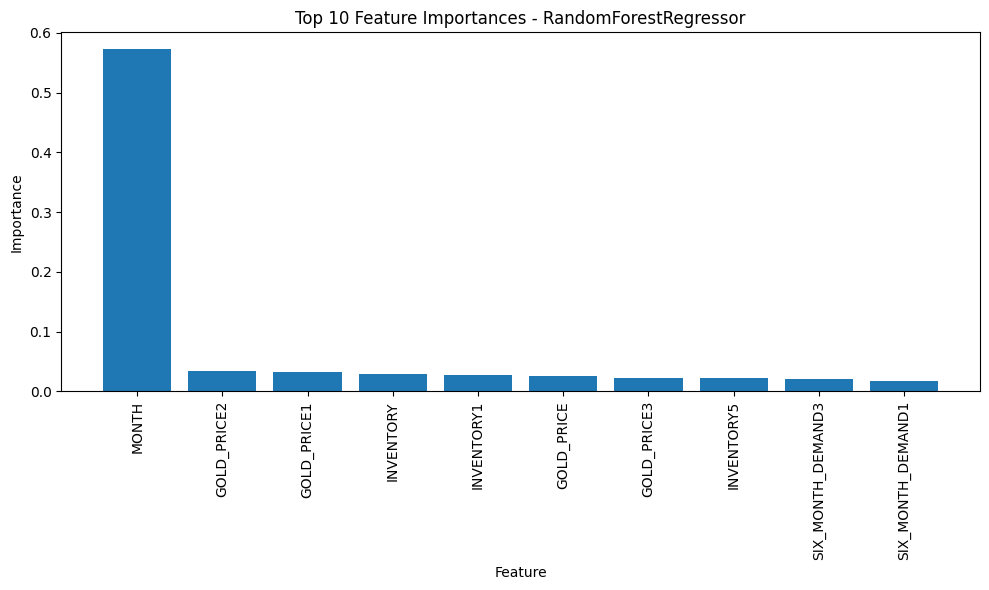

In [20]:
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': best_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Top 10 Feature Importances - RandomForestRegressor')
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [21]:
perm_importance = PermutationImportance(best_model, random_state=42).fit(X_test_s, y_test)

eli5.show_weights(perm_importance, feature_names=X.columns.tolist())

Weight,Feature
0.8460 ± 0.3660,MONTH
0.1596 ± 0.1576,GOLD_PRICE
0.0731 ± 0.0903,GOLD_PRICE1
0.0491 ± 0.0353,INVENTORY4
0.0322 ± 0.0584,SIX_MONTH_DEMAND2
0.0263 ± 0.0444,INVENTORY3
0.0247 ± 0.0191,BUY_PRICE5
0.0242 ± 0.0619,INVENTORY1
0.0202 ± 0.0421,BUY_PRICE3
0.0143 ± 0.0362,SIX_MONTH_DEMAND3


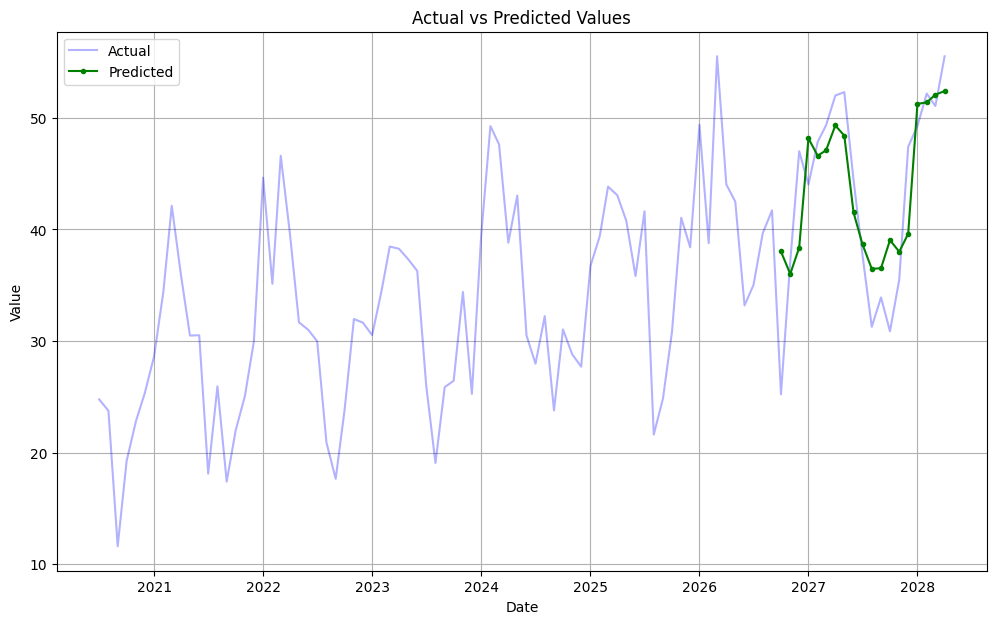

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

test_size = len(y_pred) 
train_size = len(df) - test_size
test_index = df.index[-test_size:]
y_full_actual = df['SIX_MONTH_DEMAND'].iloc[-test_size:]

plt.figure(figsize=(12, 7))

plt.plot(df['DATE'], df['SIX_MONTH_DEMAND'], 'b', label='Actual', alpha=0.3)

plt.plot(df['DATE'].iloc[-test_size:], y_pred, 'g.-', label='Predicted')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


# darts/models Test

In [26]:
from darts import TimeSeries
from darts.models import NaiveSeasonal
from darts.metrics import mae, mape
from darts.models import ExponentialSmoothing, AutoARIMA, Theta, FourTheta, RandomForest, RNNModel

c:\Users\MDY\anaconda3\envs\ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(<Axes: xlabel='DATE'>, <Axes: xlabel='DATE'>)

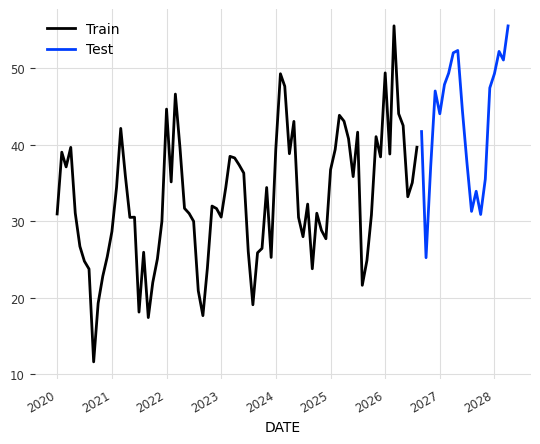

In [27]:
df = pd.read_csv('df.csv')
df['DATE'] = pd.to_datetime(df['DATE'],format='%m/%d/%Y')
df.set_index('DATE', inplace=True)

series = TimeSeries.from_dataframe(df[['SIX_MONTH_DEMAND']], freq=None)

train, test = series.split_after(0.8)
train.plot(label='Train'), test.plot(label='Test')

MAE =  7.4365529340000025
MAPE =  17.25541922151751


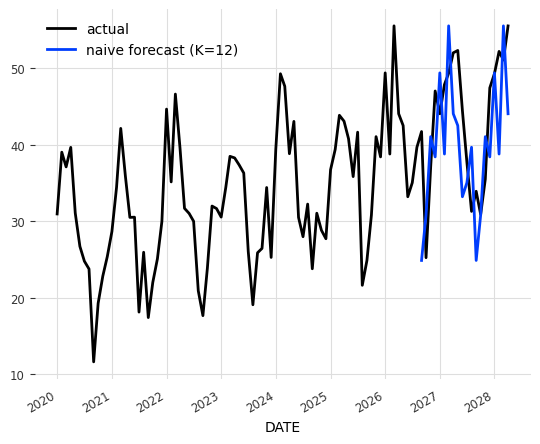

In [28]:
naive_model = NaiveSeasonal(K=12)
naive_model.fit(train)
naive_forecast = naive_model.predict(len(test))

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=12)")

print("MAE = ", mae(test, naive_forecast))
print("MAPE = ", mape(test, naive_forecast))

In [29]:
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(test))
    print(f"model {model} ---> MAE: {mae(test, forecast):.2f} | MAPE: {mape(test, forecast):.2f}%")


eval_model(ExponentialSmoothing(seasonal_periods=12))
eval_model(AutoARIMA())
eval_model(RandomForest(lags=12, n_estimators=25))
eval_model(FourTheta(seasonality_period=12))
eval_model(Theta(seasonality_period=12))

model ExponentialSmoothing(seasonal_periods=12) ---> MAE: 4.76 | MAPE: 11.37%
model AutoARIMA() ---> MAE: 8.53 | MAPE: 19.78%
model RandomForestRegressor(n_estimators=25) ---> MAE: 7.37 | MAPE: 19.03%
model FourTheta(seasonality_period=12) ---> MAE: 4.90 | MAPE: 11.50%
model Theta(seasonality_period=12) ---> MAE: 4.81 | MAPE: 11.52%


In [30]:
eval_model(RNNModel(input_chunk_length=12, output_chunk_length=1, n_epochs=2_000, random_state=42, model_name='LSTM'))

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 2/2 [00:00<00:00, 83.34it/s, train_loss=32.40] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 2/2 [00:00<00:00, 80.00it/s, train_loss=32.40]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.45it/s]
model RNNModel(input_chunk_length=12, output_chunk_length=1, n_epochs=2000, random_state=42, model_name=LSTM) ---> MAE: 9.89 | MAPE: 21.69%


Lowest MAE : 4.72 | Theta = 3.428571428571429.


<Axes: xlabel='DATE'>

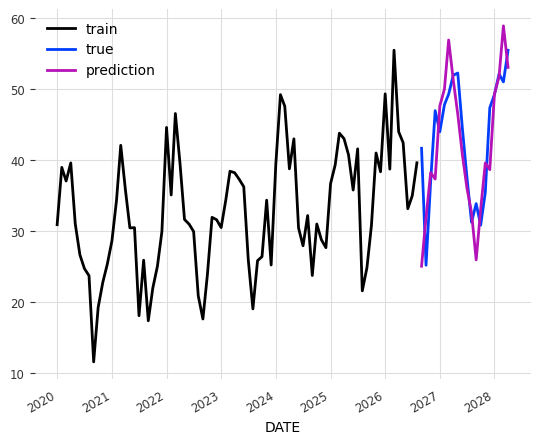

In [31]:
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(test))
    res = mape(test, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(test))

print(f"Lowest MAE : {mae(test, pred_best_theta):.2f} | Theta = {best_theta}.")

train.plot(label="train")
test.plot(label="true")
pred_best_theta.plot(label="prediction")